# 錯誤字母對分析


🔎 長度錯誤：33 筆
🔎 長度正確但內容錯：8 筆


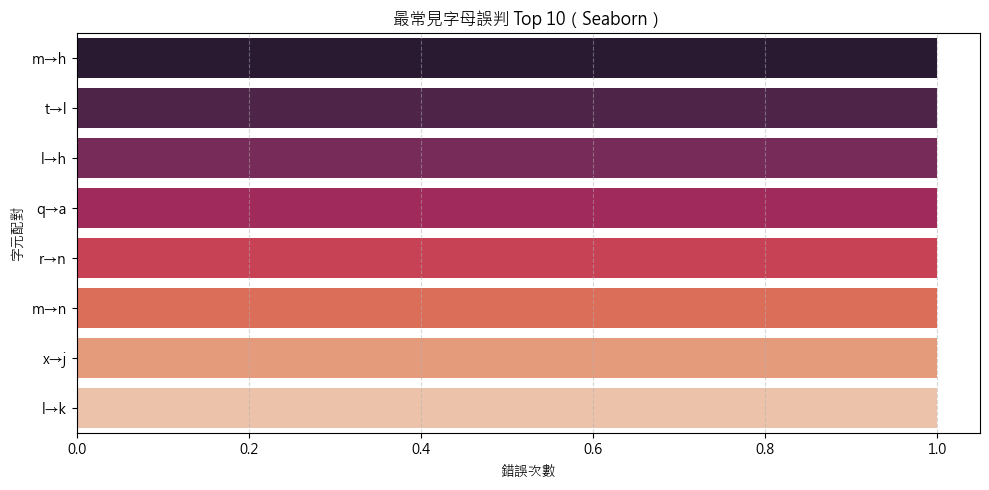

In [56]:
import sys
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 設定 matplotlib 使用支援中文的字型
plt.rcParams["font.family"] = "Microsoft JhengHei"
plt.rcParams["axes.unicode_minus"] = False


# 加入專案根目錄到 import 路徑中
BASE_DIR = Path("..").resolve()
sys.path.append(str(BASE_DIR))

# 載入錯誤清單
wrong_df = pd.read_csv(BASE_DIR / "output" / "wrong_predictions.csv")

# 分析錯誤類型
# 1.長度錯誤 vs.長度正確但字母錯
wrong_df["length_match"] = wrong_df.apply(
    lambda row: len(row["true_label"]) == len(row["predicted"]), axis=1
)

length_mismatch_count = (~wrong_df["length_match"]).sum()
length_match_count = (wrong_df["length_match"]).sum()

print(f"🔎 長度錯誤：{length_mismatch_count} 筆")
print(f"🔎 長度正確但內容錯：{length_match_count} 筆")


# 2.統計字母誤判（逐字比對）
def char_error_stats(df):
    errors = Counter()
    for row in df.itertuples():
        gt, pred = row.true_label, row.predicted
        if len(gt) != len(pred):
            continue
        for g_char, p_char in zip(gt, pred):
            if g_char != p_char:
                errors[f"{g_char}→{p_char}"] += 1
    return errors


char_errors = char_error_stats(wrong_df)

# 顯示最常見的字元錯誤 top 10
most_common_errors = char_errors.most_common(10)
labels, values = zip(*most_common_errors)


plt.figure(figsize=(10, 5))
sns.barplot(x=values, y=labels, hue=labels, palette="rocket", legend=False)
plt.title("最常見字母誤判 Top 10（Seaborn）")
plt.xlabel("錯誤次數")
plt.ylabel("字元配對")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

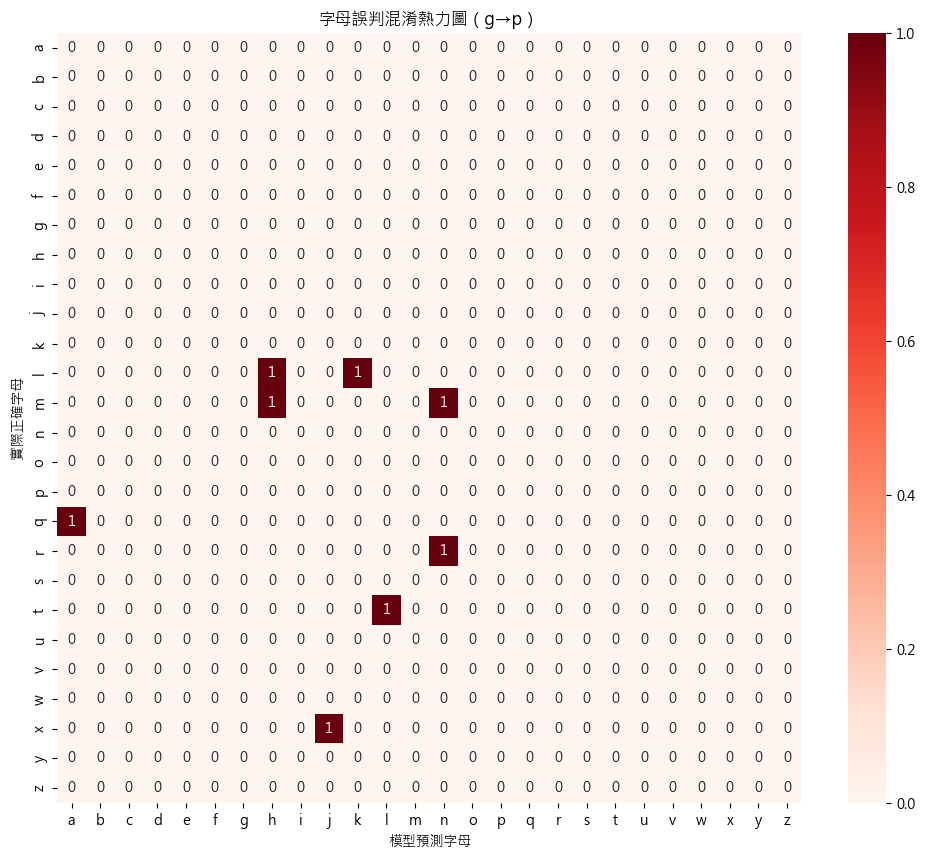

In [57]:
import numpy as np
import seaborn as sns
import string

CHARS = list(string.ascii_lowercase)
matrix = pd.DataFrame(np.zeros((26, 26)), index=CHARS, columns=CHARS)

for row in wrong_df.itertuples():
    gt, pred = row.true_label, row.predicted
    if len(gt) != len(pred):
        continue
    for g, p in zip(gt, pred):
        if g in CHARS and p in CHARS and g != p:
            matrix.loc[g, p] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Reds")
plt.title("字母誤判混淆熱力圖（g→p）")
plt.xlabel("模型預測字母")
plt.ylabel("實際正確字母")
plt.show()

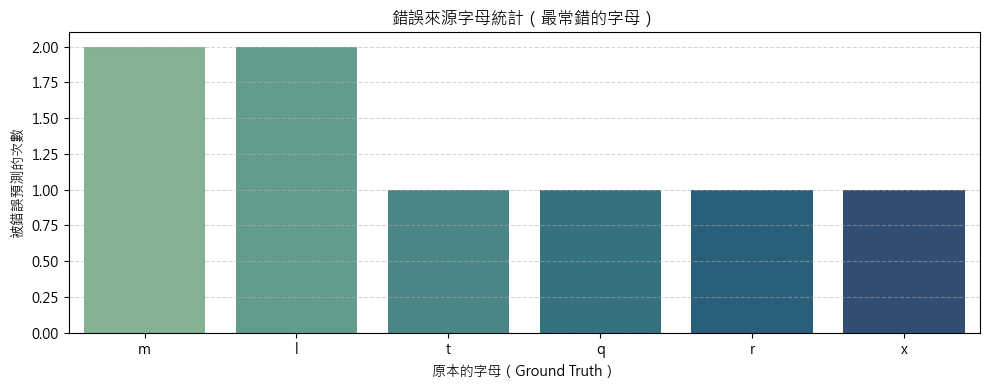

In [61]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# 統計最常被預測錯的 Ground Truth 字母
source_counter = Counter()

for row in wrong_df.itertuples():
    gt, pred = row.true_label, row.predicted
    if len(gt) != len(pred):
        continue
    for g, p in zip(gt, pred):
        if g != p:
            source_counter[g] += 1

labels, values = zip(*source_counter.most_common(10))
df = pd.DataFrame({"字母": labels, "錯誤次數": values})
df = df.sort_values("錯誤次數", ascending=False)  # 排序


plt.figure(figsize=(10, 4))
sns.barplot(data=df, x="字母", y="錯誤次數", hue="字母", palette="crest", legend=False)
plt.title("錯誤來源字母統計（最常錯的字母）")
plt.xlabel("原本的字母（Ground Truth）")
plt.ylabel("被錯誤預測的次數")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

各預測長度分布：
長度 3：32 筆 (78.0%)
長度 4：8 筆 (19.5%)
長度 5：1 筆 (2.4%)


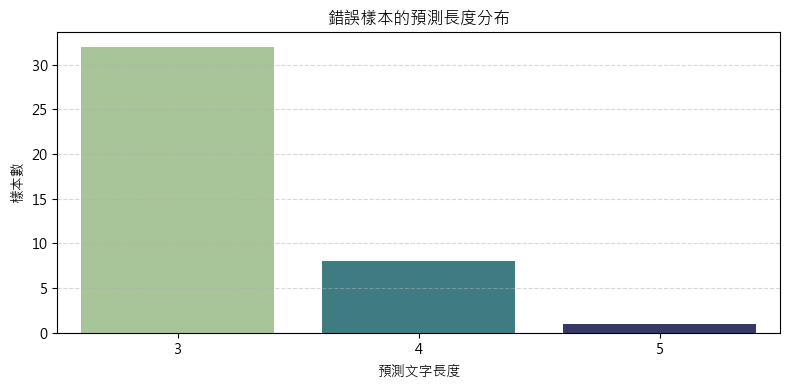

In [63]:
import pandas as pd


# 建立新欄位：預測長度
wrong_df["pred_length"] = wrong_df["predicted"].apply(len)

# 統計預測長度分布
length_counts = wrong_df["pred_length"].value_counts().sort_index()
df_len = pd.DataFrame({"長度": length_counts.index, "樣本數": length_counts.values})

# 顯示統計資訊
print("各預測長度分布：")
for l, count in length_counts.items():
    print(f"長度 {l}：{count} 筆 ({count / len(wrong_df):.1%})")

# 長度分布視覺化
plt.figure(figsize=(8, 4))
sns.barplot(
    data=df_len, x="長度", y="樣本數", hue="長度", palette="crest", legend=False
)
plt.title("錯誤樣本的預測長度分布")
plt.xlabel("預測文字長度")
plt.ylabel("樣本數")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()